# Grid Detection Visualizer

This notebook demonstrates the step-by-step process of detecting grid lines in a shuffled image using gradient analysis. We will visualize the gradients, the 1D profiles, and how the algorithm decides on the grid size.

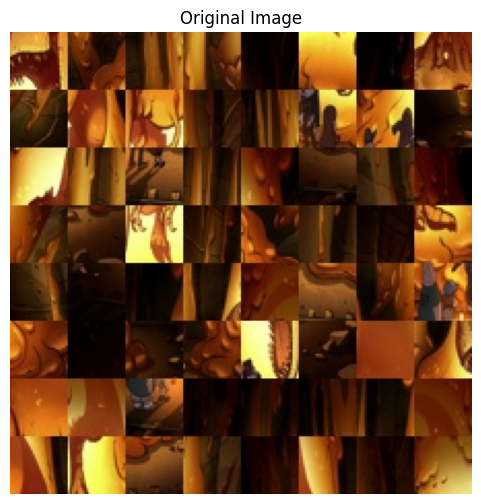

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from image_utils import load_image

%matplotlib inline

# Path to the image we want to analyze
image_path = "./Gravity Falls/puzzle_8x8/10.jpg" 

# Load and display the original image
img = load_image(image_path)

if img is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
else:
    print("Failed to load image.")

## 1. Convert to Grayscale

We convert the image to grayscale to simplify the analysis. We only care about the intensity changes (edges), not the colors.

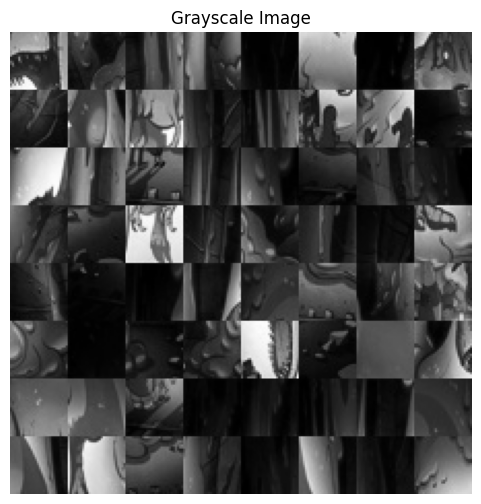

In [8]:
if len(img.shape) == 3:
    gray = np.mean(img, axis=2)
else:
    gray = img

plt.figure(figsize=(6, 6))
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

## 2. Compute Gradients

We calculate the absolute difference between adjacent pixels.
*   **Vertical Gradient (`grad_y`)**: Difference between row `i` and row `i+1`. Highlights horizontal lines.
*   **Horizontal Gradient (`grad_x`)**: Difference between column `j` and column `j+1`. Highlights vertical lines.

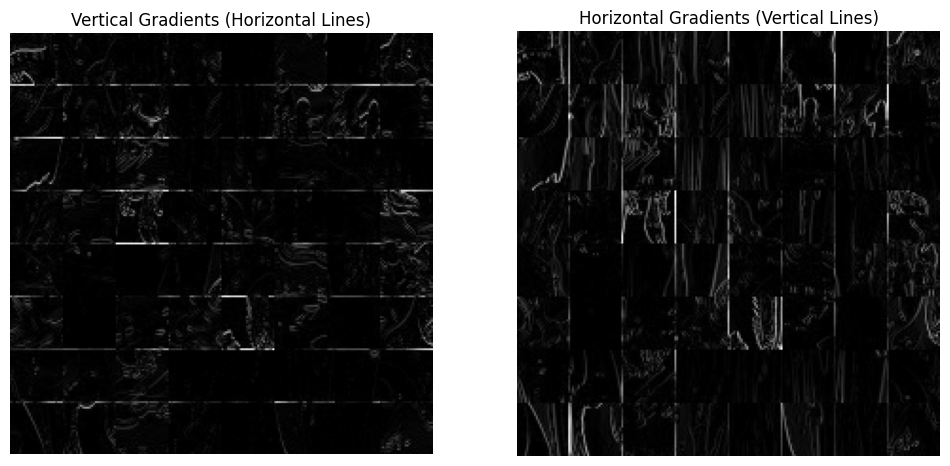

In [ ]:
# Compute gradients (absolute difference)
grad_y = np.abs(np.diff(gray, axis=0))
grad_x = np.abs(np.diff(gray, axis=1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(grad_y, cmap='gray')
ax1.set_title("Vertical Gradients (Horizontal Lines)")
ax1.axis('off')

ax2.imshow(grad_x, cmap='gray')
ax2.set_title("Horizontal Gradients (Vertical Lines)")
ax2.axis('off')

plt.show()

## 3. Project to 1D Profiles

We average the gradients along the axes to get a 1D profile.
*   **Row Profile**: Average of `grad_y` along rows. Peaks indicate horizontal grid lines.
*   **Column Profile**: Average of `grad_x` along columns. Peaks indicate vertical grid lines.

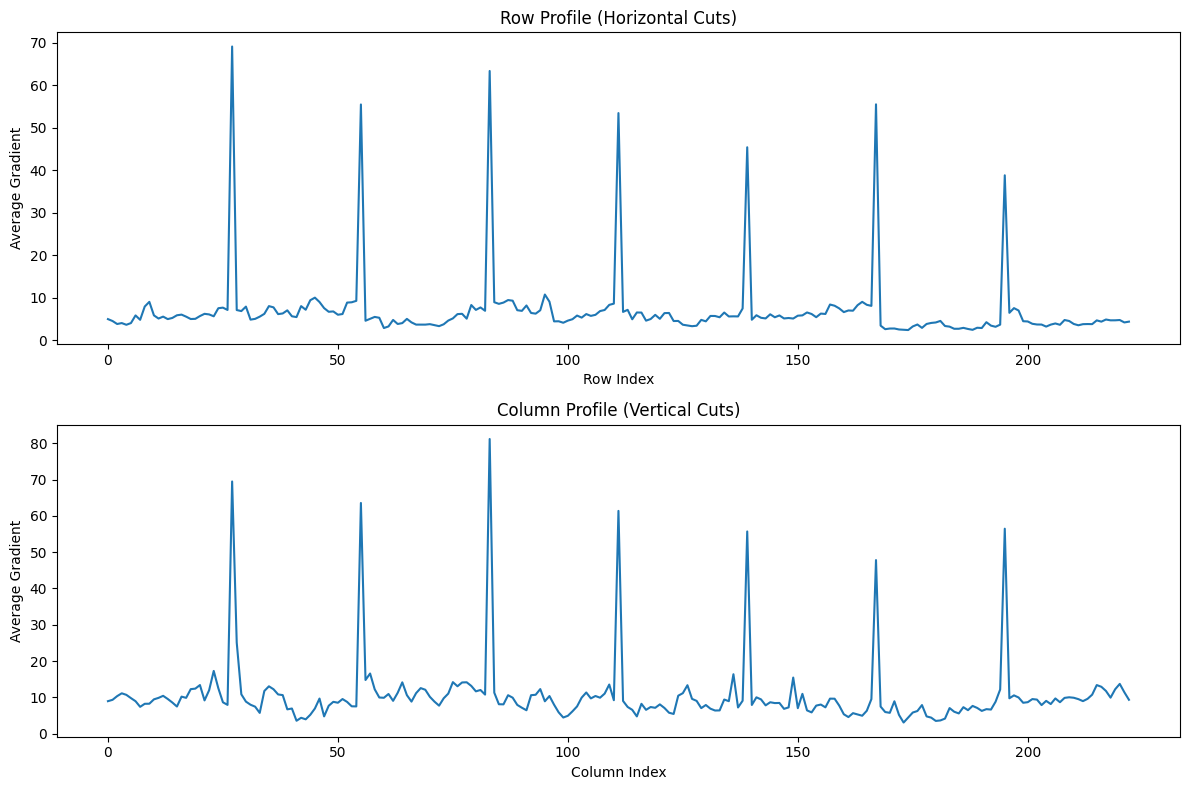

In [ ]:
# Project to 1D profiles
row_profile = np.mean(grad_y, axis=1)
col_profile = np.mean(grad_x, axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(row_profile)
ax1.set_title("Row Profile (Horizontal Cuts)")
ax1.set_xlabel("Row Index")
ax1.set_ylabel("Average Gradient")

ax2.plot(col_profile)
ax2.set_title("Column Profile (Vertical Cuts)")
ax2.set_xlabel("Column Index")
ax2.set_ylabel("Average Gradient")

plt.tight_layout()
plt.show()

## 4. Check for Grid Cuts

We check specific positions (1/2, 1/4, 1/8, etc.) to see if there are peaks in the gradient profile.
We calculate a "score" for each grid size by checking the gradient magnitude at the expected cut locations relative to the average gradient.

Checking 8x8 (Rows) cuts:
  Cut at 0.12 (index 26): Peak=69.14, Score=9.76
  Cut at 0.38 (index 82): Peak=63.38, Score=8.94
  Cut at 0.62 (index 138): Peak=45.43, Score=6.41
  Cut at 0.88 (index 194): Peak=38.84, Score=5.48
  -> Average Score for 8x8 (Rows): 7.65



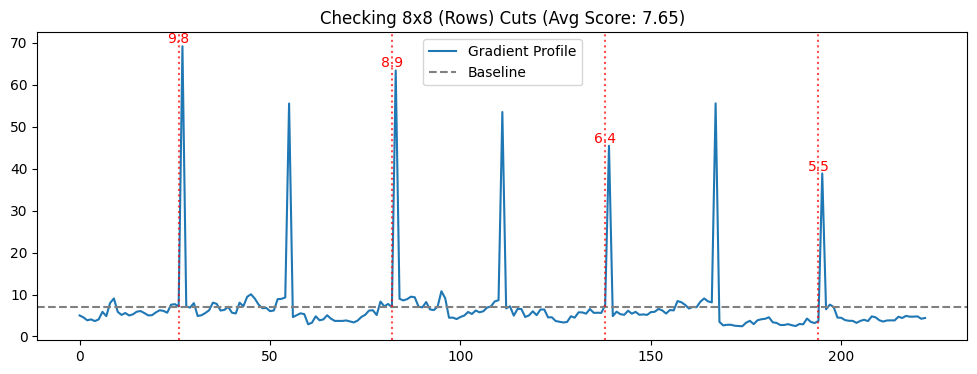

Checking 8x8 (Cols) cuts:
  Cut at 0.12 (index 26): Peak=69.50, Score=6.53
  Cut at 0.38 (index 82): Peak=81.21, Score=7.63
  Cut at 0.62 (index 138): Peak=55.72, Score=5.23
  Cut at 0.88 (index 194): Peak=56.48, Score=5.30
  -> Average Score for 8x8 (Cols): 6.17



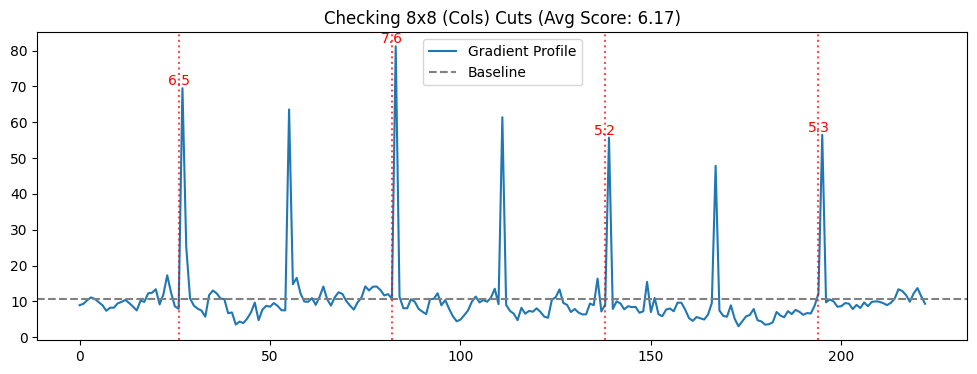

Checking 4x4 (Rows) cuts:
  Cut at 0.25 (index 54): Peak=55.50, Score=7.83
  Cut at 0.75 (index 166): Peak=55.53, Score=7.84
  -> Average Score for 4x4 (Rows): 7.83



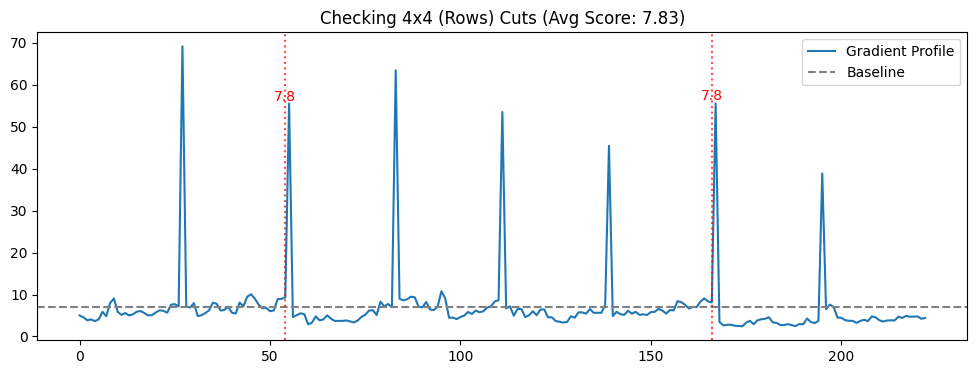

Checking 4x4 (Cols) cuts:
  Cut at 0.25 (index 54): Peak=63.57, Score=5.97
  Cut at 0.75 (index 166): Peak=47.82, Score=4.49
  -> Average Score for 4x4 (Cols): 5.23



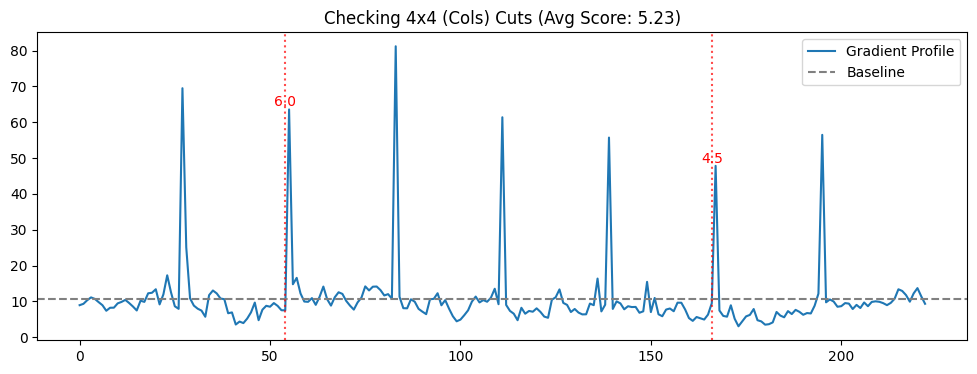

Checking 2x2 (Rows) cuts:
  Cut at 0.50 (index 110): Peak=53.48, Score=7.55
  -> Average Score for 2x2 (Rows): 7.55



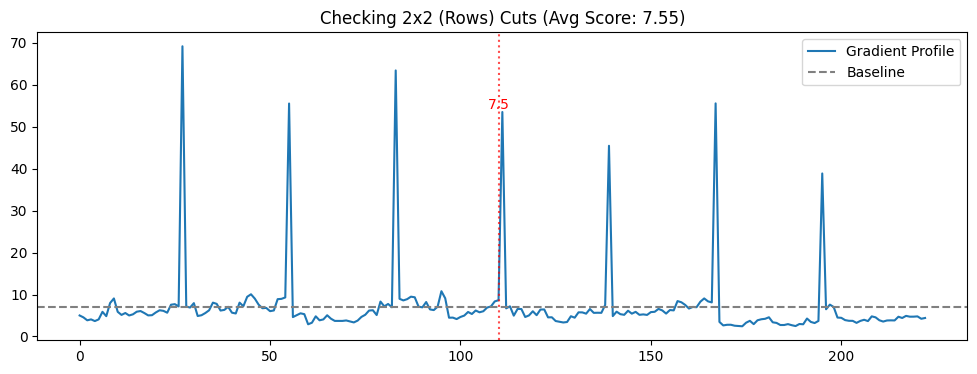

Checking 2x2 (Cols) cuts:
  Cut at 0.50 (index 110): Peak=61.39, Score=5.76
  -> Average Score for 2x2 (Cols): 5.76



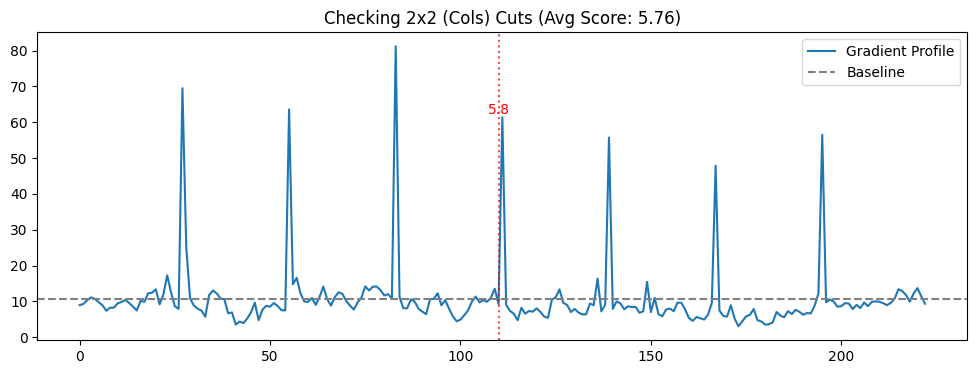

In [ ]:
def check_cuts_visual(profile, fractions, name):
    length = len(profile)
    scores = []
    baseline = np.mean(profile)
    
    plt.figure(figsize=(12, 4))
    plt.plot(profile, label="Gradient Profile")
    plt.axhline(baseline, color='gray', linestyle='--', label="Baseline")
    
    print(f"Checking {name} cuts:")
    
    for frac in fractions:
        idx = int(length * frac) - 1
        start = max(0, idx - 2)
        end = min(length, idx + 3)
        
        if start >= end:
            continue
            
        peak_val = np.max(profile[start:end])
        score = peak_val / (baseline + 1e-6)
        scores.append(score)
        
        print(f"  Cut at {frac:.2f} (index {idx}): Peak={peak_val:.2f}, Score={score:.2f}")
        
        plt.axvline(idx, color='r', linestyle=':', alpha=0.7)
        plt.text(idx, peak_val, f"{score:.1f}", color='red', ha='center', va='bottom')

    avg_score = np.mean(scores) if scores else 0
    print(f"  -> Average Score for {name}: {avg_score:.2f}\n")
    
    plt.title(f"Checking {name} Cuts (Avg Score: {avg_score:.2f})")
    plt.legend()
    plt.show()
    return avg_score

# Check 8x8
score_8_y = check_cuts_visual(row_profile, [1/8, 3/8, 5/8, 7/8], "8x8 (Rows)")
score_8_x = check_cuts_visual(col_profile, [1/8, 3/8, 5/8, 7/8], "8x8 (Cols)")

# Check 4x4
score_4_y = check_cuts_visual(row_profile, [1/4, 3/4], "4x4 (Rows)")
score_4_x = check_cuts_visual(col_profile, [1/4, 3/4], "4x4 (Cols)")

# Check 2x2
score_2_y = check_cuts_visual(row_profile, [1/2], "2x2 (Rows)")
score_2_x = check_cuts_visual(col_profile, [1/2], "2x2 (Cols)")

## 5. Final Decision

We compare the scores against a threshold to determine the most likely grid size. We check from largest (8x8) to smallest (2x2).

In [ ]:
THRESHOLD = 1.5

detected_size = None

if score_8_y > THRESHOLD and score_8_x > THRESHOLD:
    detected_size = 8
elif score_4_y > THRESHOLD and score_4_x > THRESHOLD:
    detected_size = 4
elif score_2_y > THRESHOLD and score_2_x > THRESHOLD:
    detected_size = 2

print(f"Final Detected Grid Size: {detected_size}x{detected_size}" if detected_size else "Could not detect grid size.")

Final Detected Grid Size: 8x8
